In [262]:
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import urbanpy as up
import contextily as cx
from pathlib import Path
from pandarallel import pandarallel
from shapely.geometry import Polygon
from tqdm.auto import tqdm

In [2]:
pandarallel.initialize(progress_bar=True, nb_workers=16)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [265]:
tqdm.pandas()

# Geocoding con un Nomatin Server

## Leemos los datos a usar

In [3]:
df = pd.read_stata('inputs/rucs_firmas_20142020.dta')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240151 entries, 0 to 240150
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ruc                   240151 non-null  float64
 1   CODIGO_TIPO_VIA       240151 non-null  object 
 2   DESCRIPCION_TIPO_VIA  240151 non-null  object 
 3   NOMBRE_VIA            240151 non-null  object 
 4   PUERTA                240151 non-null  object 
 5   MANZANA               240151 non-null  object 
 6   LOTE                  240151 non-null  object 
 7   PISO                  240151 non-null  object 
 8   INTERIOR              240151 non-null  object 
 9   DIR_DPTO              240151 non-null  object 
 10  KILOMETRO             240151 non-null  object 
 11  REFERENCIA            240151 non-null  object 
 12  DIR_TIPOZONA          240151 non-null  object 
 13  tipo_zona             240151 non-null  object 
 14  DIR_NOMZONA           240151 non-null  object 
 15  

In [5]:
departamentos = gpd.read_file('inputs/departamentos/')

In [6]:
res = 4
peru_hexs = up.geom.gen_hexagons(res, departamentos)
print(f'Hex count @ res {res}:', peru_hexs.shape[0])

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/urbanpy/geom/geom.py:168: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  city_poly = city.explode().reset_index(drop=True)


Hex count @ res 4: 634


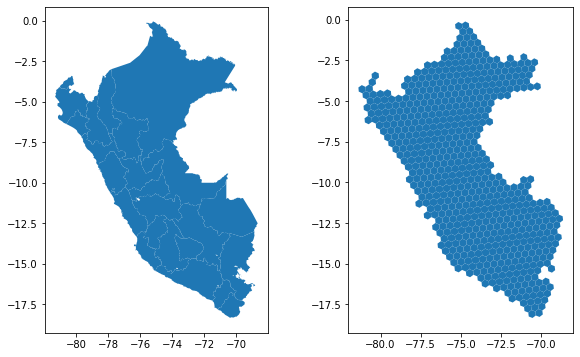

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
departamentos.plot(ax=axes[0])
peru_hexs.plot(ax=axes[1])
plt.show()

## Preparamos las funciones para geocodificar

In [8]:
def geocode(row, server='https://nominatim.openstreetmap.org/'):
    params = {'q': row['q'], 'limit': 1, 'format': 'json'}
    response = requests.get(server+'/search', params=params)
    data = response.json()
    if server == 'https://nominatim.openstreetmap.org/':
        time.sleep(1) # Usage limits
    return data

In [256]:
def geocoding_process(fn, df, geocode_fn):
    if Path(fn+'.csv').exists():
        geocoded_df = pd.read_csv(fn+'.csv', index_col=0)
    else:
        geocoded = df.parallel_apply(geocode_fn, axis=1, server=NOMINATIM_SERVER)
        geocoded_exploded = geocoded.explode() # unpack lists
        geocoded_df = pd.json_normalize(geocoded_exploded) # Series of dicts -> DataFrame
        geocoded_df.to_csv(fn+'.csv')
        print(geocoded_df)
        
    # NaNs
    print(f"""
Geocoded observations:
---------------------

Total:
-----
{geocoded_df['lat'].isna().value_counts()}

Percentage:
----------
{(geocoded_df['lat'].isna().value_counts() / geocoded_df.shape[0] * 100).round(2)}

OSM Data types:
--------------
{geocoded_df['osm_type'].value_counts()}

OSM Class:
---------
{geocoded_df['class'].value_counts()}

OSM Class type:
--------------
{geocoded_df['type'].value_counts()}
    """)

    if Path(fn+'.geojson').exists():
        geocoded_gdf = gpd.read_file(fn+'.geojson')
    else:
        geocoded_gdf = gpd.GeoDataFrame(
            data=geocoded_df,
            geometry=gpd.points_from_xy(geocoded_df['lon'], geocoded_df['lat']),
            crs='EPSG:4326'
        )
        geocoded_gdf = geocoded_gdf.drop('boundingbox', axis=1) # Can't save list type in geojson format
        geocoded_gdf.to_file(fn+'.geojson', driver='GeoJSON')

    print(f"""
GeoDataFrame (first 5 observations):
-----------------------------------
{geocoded_gdf.head()}
    """)
    
    # Point map
    ax = geocoded_gdf.plot(figsize=(10, 10))
    cx.add_basemap(ax, crs=geocoded_gdf.crs, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off()
    plt.show()

    # Count points per hexagon
    geocoded_gdf['count'] = 1
    peru_hexs_counts = up.geom.merge_shape_hex(peru_hexs, geocoded_gdf.dropna(), agg={'count':'sum'})
    print(peru_hexs_counts.describe())
    ax = peru_hexs_counts.plot('count', vmin=0, vmax=200, figsize=(30,10), legend=True, alpha=0.5)
    cx.add_basemap(ax, crs=geocoded_gdf.crs, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off()
    plt.show()
    
    return geocoded_df, geocoded_gdf

## Primero filtraremos los que sí tienen "NOMBRE_VIA" y "PUERTA" e intentaremos geocodificarlas

In [261]:
NOMINATIM_SERVER = 'http://192.168.18.18:8080'

In [11]:
filter_ = (df['NOMBRE_VIA'] != '-') & (~df['PUERTA'].isin(['-','S/N','SN','']))

In [12]:
columns = ['PUERTA', 'DESCRIPCION_TIPO_VIA', 'NOMBRE_VIA', 'DISTRITO', 'PROVINCIA', 'DEPARTAMENTO', 'UBIGEO']
indexs = df[filter_].index

In [13]:
df.shape, indexs.shape, indexs.shape[0]/df.shape[0]

((240151, 29), (161327,), 0.671773176043406)

In [14]:
df_sample = df.loc[indexs, columns]

In [15]:
df_sample['street_name'] = df_sample[['DESCRIPCION_TIPO_VIA', 'NOMBRE_VIA', 'PUERTA']].apply(lambda x: ' '.join(x).lower(), axis=1)
df_sample['location'] = df_sample[['DISTRITO', 'PROVINCIA', 'DEPARTAMENTO']].apply(lambda x: ', '.join(x).lower(), axis=1)
df_sample['q'] = df_sample[['street_name', 'location']].apply(lambda x: ', '.join(x).lower(), axis=1)

In [16]:
df_sample['q']

0                jiron apurimac 521, callao, callao, callao
1            avenida argentina 1646, callao, callao, callao
2         avenida augusto perez aranibar 1872, san isidr...
3            avenida argentina 3719, callao, callao, callao
5            avenida argentina 6360, callao, callao, callao
                                ...                        
240144       avenida costanera 2576, san miguel, lima, lima
240145    avenida sergio bernales 347, surquillo, lima, ...
240146    calle micaela bastidas 202, villa maria del tr...
240147    calle prohogar 918, miraflores, arequipa, areq...
240148    calle baca mattos 1194, lambayeque, lambayeque...
Name: q, Length: 161327, dtype: object


Geocoded observations:
---------------------

Total:
-----
False    102114
True      59213
Name: lat, dtype: int64

Percentage:
----------
False    63.3
True     36.7
Name: lat, dtype: float64

OSM Data types:
--------------
way         97012
node         4890
relation      212
Name: osm_type, dtype: int64

OSM Class:
---------
highway     88654
place        6261
building     2132
shop         1785
amenity      1640
office       1217
tourism       291
leisure        57
craft          30
landuse        22
boundary        7
man_made        5
club            5
natural         4
aeroway         2
historic        1
waterway        1
Name: class, dtype: int64

OSM Class type:
--------------
residential         47229
secondary           15351
tertiary            11539
primary              9441
house                6139
                    ...  
parking_entrance        1
locksmith               1
mobile_phone            1
taxi                    1
cemetery                1
Name: type, Length:

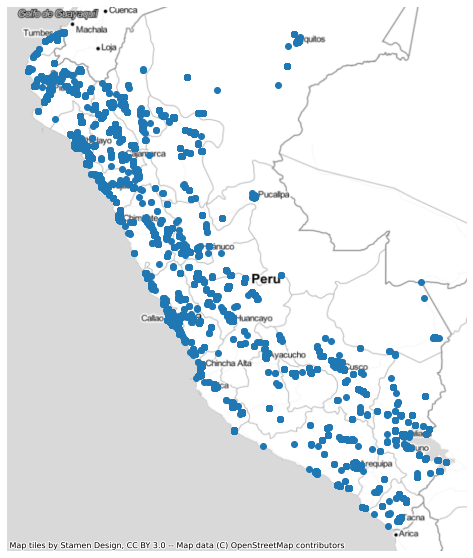

/var/folders/kb/8rst2bm96jq7g3ykfrtw15zc0000gp/T/ipykernel_9737/1200115963.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  geocoded_df, geocoded_gdf = geocoding_process(


              count
count    222.000000
mean     450.184685
std     4181.623995
min        1.000000
25%        4.000000
50%       19.000000
75%      114.000000
max    62029.000000


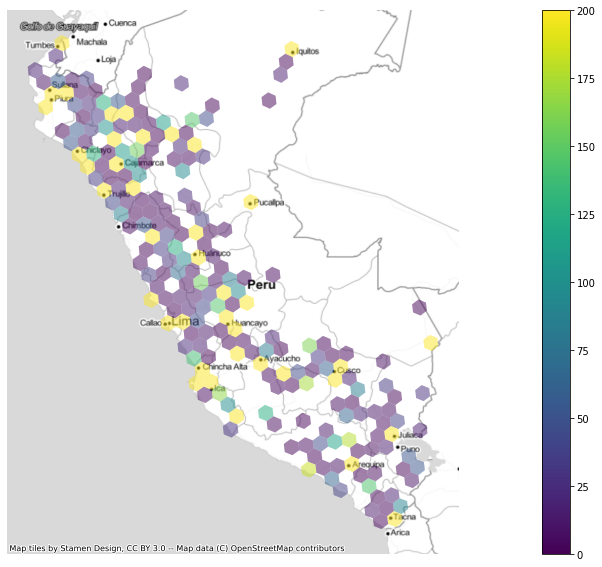

In [160]:
geocoded_df, geocoded_gdf = geocoding_process(
    fn='outputs/geocoded_df', df=df_sample, geocode_fn=geocode)

In [18]:
geocoded_df.head()

,place_id,licence,osm_type,osm_id,boundingbox,lat,lon,display_name,class,type,importance
0,480319.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,326819625.0,"['-12.0643987', '-12.0640482', '-77.1438679', ...",-12.064195,-77.142408,"Jirón Apurímac, Callao, Lima Metropolitana, Ca...",highway,residential,0.4
1,336252.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,43476929.0,"['-12.0517223', '-12.0514915', '-77.1390019', ...",-12.051599,-77.136316,"Avenida Argentina, Nuevo Puerto, Callao, Lima ...",highway,primary,0.6
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,336252.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,43476929.0,"['-12.0517223', '-12.0514915', '-77.1390019', ...",-12.051599,-77.136316,"Avenida Argentina, Nuevo Puerto, Callao, Lima ...",highway,primary,0.6


In [19]:
geocoded_gdf

,place_id,licence,osm_type,osm_id,lat,lon,display_name,class,type,importance,geometry,count
0,480319.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,326819625.0,-12.0641953,-77.1424078,"Jirón Apurímac, Callao, Lima Metropolitana, Ca...",highway,residential,0.4,POINT (-77.14241 -12.06420),1
1,336252.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,43476929.0,-12.0515994,-77.1363159,"Avenida Argentina, Nuevo Puerto, Callao, Lima ...",highway,primary,0.6,POINT (-77.13632 -12.05160),1
2,NaN,None,None,NaN,None,None,None,None,None,NaN,None,1
3,NaN,None,None,NaN,None,None,None,None,None,NaN,None,1
4,336252.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,43476929.0,-12.0515994,-77.1363159,"Avenida Argentina, Nuevo Puerto, Callao, Lima ...",highway,primary,0.6,POINT (-77.13632 -12.05160),1
...,...,...,...,...,...,...,...,...,...,...,...,...
161322,784025.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,834794998.0,-12.0853067,-77.0970258,"Avenida Costanera, San Miguel, Lima, Lima Metr...",highway,primary,0.7,POINT (-77.09703 -12.08531),1
161323,345848.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,24332076.0,-12.1181506,-77.0152499,"Avenida Sergio Bernales, Surquillo, Lima, Lima...",highway,tertiary,0.7,POINT (-77.01525 -12.11815),1
161324,508780.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,408678500.0,-12.1369273,-76.9492306,"Calle Micaela Bastidas, Villa María del Triunf...",highway,residential,0.9,POINT (-76.94923 -12.13693),1
161325,593409.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,538094089.0,-16.3943896,-71.5215922,"Prohogar, Las Palmeras, Miraflores, Arequipa, ...",highway,tertiary,0.5,POINT (-71.52159 -16.39439),1


### Ahora limpiaremos las direcciones de las observaciones que no pudieron ser geocodificadas en el caso anterior

In [20]:
df_retry_ix = df_sample[geocoded_df['lat'].isna().values].index

In [21]:
df_retry = df.loc[df_retry_ix, :]

In [22]:
df_sample.shape, df_retry.shape

((161327, 10), (59213, 29))

### Podemos utilizar los datos del censo a nivel de manzana para georrefenciar aproximadamente algunas firmas

In [23]:
censo_mz = gpd.read_file('inputs/Manzanas/')

In [24]:
censo_mz.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 106889 entries, 0 to 106888
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDMANZANA   106889 non-null  object  
 1   CODZONA     81320 non-null   object  
 2   CODMZNA     81346 non-null   object  
 3   CLASIFICAC  106889 non-null  int64   
 4   UBIGEO      106889 non-null  object  
 5   NOMBREMZNA  57384 non-null   object  
 6   URBANIZACI  83527 non-null   object  
 7   NSE07       59635 non-null   object  
 8   POB07       106889 non-null  int64   
 9   VIV07       106889 non-null  int64   
 10  NSE16       78221 non-null   object  
 11  POB16       106889 non-null  int64   
 12  VIV         106889 non-null  int64   
 13  LONGITUDE   106889 non-null  float64 
 14  LATITUDE    106889 non-null  float64 
 15  geometry    106889 non-null  geometry
dtypes: float64(2), geometry(1), int64(5), object(8)
memory usage: 13.0+ MB


In [25]:
geo_cols = ['IDMANZANA', 'LATITUDE', 'LONGITUDE']
censo_mz_cods = censo_mz[censo_mz['CODMZNA'].notna()][geo_cols]

In [26]:
censo_cols = ['CNS_UBIGEO', 'CNS_ZONA_CENSAL', 'CNS_MZ_CENSAL', 'CNS_MZSUF_CENSAL']
df_retry_censo = df_retry[~df_retry['CNS_MZ_CENSAL'].isin(['', 'NUL'])][censo_cols]
df_retry_censo['IDMANZANA'] = df_retry_censo.sum(axis=1)

In [27]:
df_retry_censo_geocoded = df_retry_censo.reset_index().merge(
    censo_mz_cods, on='IDMANZANA', how='inner').set_index('index')

In [28]:
df_retry_censo_geocoded.shape

(920, 7)

### Ahora intentemos utilizar el servidor de Nominatim de nuevo pero facilitemos la busqueda indicandole el area geografica del distrito donde debe buscar la direccion

In [29]:
distritos = gpd.read_file('inputs/distritos/')

In [30]:
distritos.shape, distritos['IDDIST'].unique().shape

((1873, 11), (1873,))

In [31]:
distritos[['minx', 'miny', 'maxx', 'maxy']] = distritos.geometry.bounds

In [32]:
df_retry.shape

(59213, 29)

In [33]:
df_retry_nominatim = df_retry.drop(df_retry_censo_geocoded.index)

In [34]:
def geocode_w_poly(row, server='https://nominatim.openstreetmap.org/'):
    params = {'q': row['q'], 'limit': 1, 'format': 'json', 'bounded': 1,
              'viewbox':','.join([str(val) for val in row[['minx', 'miny', 'maxx', 'maxy']]])}
    response = requests.get(server+'/search', params=params)
    data = response.json()
    if server == 'https://nominatim.openstreetmap.org/':
        time.sleep(1) # Usage limits
    return data

In [35]:
df_retry_nominatim_vb = df_retry_nominatim.reset_index().merge(
    distritos[['IDDIST', 'minx', 'miny', 'maxx', 'maxy']], 
    how='inner',
    left_on='UBIGEO', 
    right_on='IDDIST'
).set_index('index')

In [36]:
df_retry_nominatim_vb.shape

(58284, 34)

In [37]:
df_retry_nominatim_vb['q'] = df_retry_nominatim_vb['NOMBRE_VIA'] + ' ' + df_retry_nominatim_vb['PUERTA']
df_retry_nominatim_vb['q'] = df_retry_nominatim_vb['q'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True).str.lower()
df_retry_nominatim_vb['q']

index
2           augusto perez aranibar 1872
86                         calle 31 125
123       francisco canaval y morey 522
238                    las begonias 415
256                        calle 25 195
                      ...              
232196                   cocochillo 325
233814       bernardo guebles meier 356
234300                predio panteon i 
235192                       arequipa 0
238696           jorge chavez darwin 15
Name: q, Length: 58284, dtype: object


Geocoded observations:
---------------------

Total:
-----
True     37677
False    20607
Name: lat, dtype: int64

Percentage:
----------
True     64.64
False    35.36
Name: lat, dtype: float64

OSM Data types:
--------------
way         19629
node          843
relation      134
Name: osm_type, dtype: int64

OSM Class:
---------
highway     18937
place         897
amenity       179
building      167
shop          105
landuse        98
office         94
tourism        55
boundary       55
leisure         5
aeroway         4
craft           3
waterway        3
man_made        2
natural         2
historic        1
Name: class, dtype: int64

OSM Class type:
--------------
residential         14717
tertiary             1721
secondary            1337
house                 571
primary               300
                    ...  
stationery              1
motorcycle              1
amusement_arcade        1
association             1
peak                    1
Name: type, Length: 123, dtype: int64

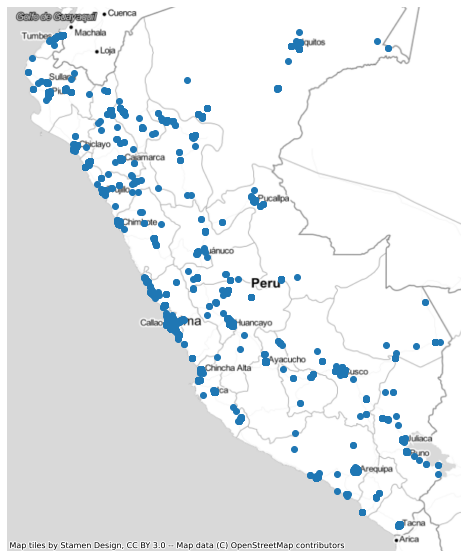

/var/folders/kb/8rst2bm96jq7g3ykfrtw15zc0000gp/T/ipykernel_9737/952200113.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  geocoded_df_retry_nominatim_vb, geocoded_gdf_retry_nominatim_vb = geocoding_process(


              count
count    149.000000
mean     136.798658
std     1164.366160
min        1.000000
25%        1.000000
50%        3.000000
75%       15.000000
max    14177.000000


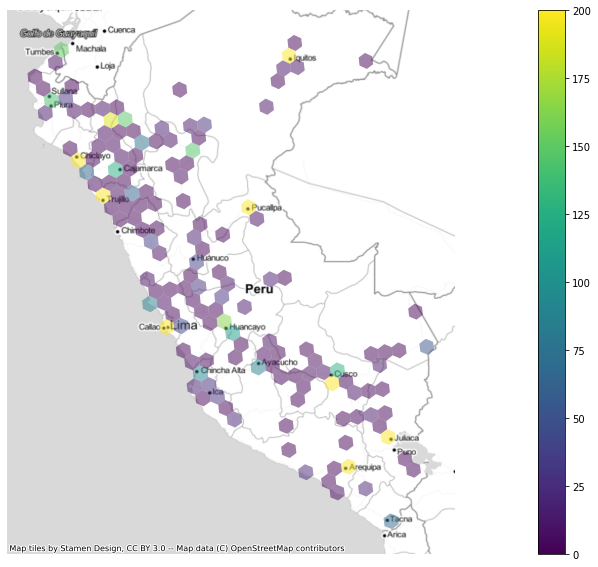

In [161]:
geocoded_df_retry_nominatim_vb, geocoded_gdf_retry_nominatim_vb = geocoding_process(
    fn='outputs/geocoded_df_retry_nominatim_vb', df=df_retry_nominatim_vb, geocode_fn=geocode_w_poly)

#### Veamos algunas direcciones geocodificadas para verificar

In [39]:
for address in geocoded_gdf_retry_nominatim_vb[geocoded_gdf_retry_nominatim_vb['lat'].notna()]['display_name'].head(15).tolist():
    print(address)
    print()

Jirón Caros Neuhaus Rizo Patrón, San Isidro, Lima, Lima Metropolitana, Lima, 15000, Perú

Jirón Oscar Avilés, San Isidro, Lima, Lima Metropolitana, Lima, 15000, Perú

Calle Manuel S. Ugarte y Moscoso, Orrantia del Mar, San Isidro, Lima, Lima Metropolitana, Lima, 15076, Perú

Embajada de Alemania, 144, Avenida Dionisio Derteano, Centro financiero de San Isidro, San Isidro, Lima, Lima Metropolitana, Lima, AN ISIDRO 15036, Perú

Avenida José Galvez Barrenechea, Corpac, San Isidro, Lima, Lima Metropolitana, Lima, 15000, Perú

Miguel Dasso, San Isidro, Lima, Lima Metropolitana, Lima, 15073, Perú

Los Pelicanos, Centro financiero de San Isidro, San Isidro, Lima, Lima Metropolitana, Lima, AN ISIDRO 15036, Perú

Avenida República de Colombia, Centro financiero de San Isidro, San Isidro, Lima, Lima Metropolitana, Lima, 27, Perú

Luis Felipe Villaran, San Isidro, Lima, Lima Metropolitana, Lima, 15073, Perú

Miguel Dasso, San Isidro, Lima, Lima Metropolitana, Lima, 15073, Perú

Miguel Dasso, San 

In [40]:
df.loc[df_retry_nominatim_vb[geocoded_gdf_retry_nominatim_vb['lat'].notna().values].index, :][['NOMBRE_VIA', 'DISTRITO', 'PROVINCIA']].head(15)

,NOMBRE_VIA,DISTRITO,PROVINCIA
index,,,
86,CALLE 31,SAN ISIDRO,LIMA
256,CALLE 25,SAN ISIDRO,LIMA
351,MANUEL UGARTE Y MOSCOSO,SAN ISIDRO,LIMA
414,DIONISIO DERTEANO,SAN ISIDRO,LIMA
828,"GALVEZ BARRENECHEA, JOSE",SAN ISIDRO,LIMA
1268,MIGUEL DASSO,SAN ISIDRO,LIMA
1354,LOS PELICANOS,SAN ISIDRO,LIMA
1359,AV REPUBLICA DE COLOMBIA,SAN ISIDRO,LIMA
1399,LUIS FELIPE VILLARAN,SAN ISIDRO,LIMA


### Aun tenemos un grupo de direcciones que no pudimos goereferenciar. Una opcion podria ser utilizar el API de Nominatim en la nube (~5 horas)

Debido a que este proceso demora bastante tiempo vamos a correrlo en segundo plano vamos a:

1. Guardar los datos
2. Correr el proceso en un notebook o script aparte

In [44]:
df_second_retry_ix = df_retry_nominatim_vb[geocoded_gdf_retry_nominatim_vb['lat'].isna().values].index

In [42]:
df_second_retry = df.loc[df_second_retry_ix, :]

In [43]:
df_second_retry.head()

,ruc,CODIGO_TIPO_VIA,DESCRIPCION_TIPO_VIA,NOMBRE_VIA,PUERTA,MANZANA,LOTE,PISO,INTERIOR,DIR_DPTO,...,CNS_FRENTE,DEPARTAMENTO,PROVINCIA,DISTRITO,CAPITAL,codigo_prov,Region,CODODEI,ODEI,UBIGEO
index,,,,,,,,,,,,,,,,,,,,,
2,2.010000e+10,01,AVENIDA,AUGUSTO PEREZ ARANIBAR,1872,-,-,,-,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
123,2.010005e+10,01,AVENIDA,FRANCISCO CANAVAL Y MOREY,522,-,-,,-,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
238,2.010009e+10,01,AVENIDA,LAS BEGONIAS,415,-,-,,1201,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
288,2.010012e+10,02,CALLE,GERMAN SCHEREIBER,276,-,-,,-,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
305,2.010012e+10,01,AVENIDA,FELIPE PARDO Y ALIAGA,652,-,-,,1201,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131


In [47]:
df_second_retry.to_csv('outputs/df_second_retry.csv')

### Por ultimo buscaremos geocoficar las observaciones que no tienen direccion

#### Para comenzar veamos cuantas podemos ubicar en una manzana censal

In [56]:
df_sin_direccion = df.drop(indexs)

In [57]:
censo_cols = ['CNS_UBIGEO', 'CNS_ZONA_CENSAL', 'CNS_MZ_CENSAL', 'CNS_MZSUF_CENSAL']
df_sin_direccion_censo = df_sin_direccion[~df_sin_direccion['CNS_MZ_CENSAL'].isin(['', 'NUL'])][censo_cols]
df_sin_direccion_censo['IDMANZANA'] = df_sin_direccion_censo.sum(axis=1)

In [58]:
df_sin_direccion_censo.shape

(1014, 5)

In [59]:
df_sin_direccion_censo_geocoded = df_sin_direccion_censo.reset_index().merge(
    censo_mz_cods, on='IDMANZANA', how='inner').set_index('index')

In [60]:
df_sin_direccion_censo_geocoded.shape

(445, 7)

In [61]:
df_sin_direccion_censo_geocoded

,CNS_UBIGEO,CNS_ZONA_CENSAL,CNS_MZ_CENSAL,CNS_MZSUF_CENSAL,IDMANZANA,LATITUDE,LONGITUDE
index,,,,,,,
526,070101,02800,023,,07010102800023,-12.032081,-77.096917
706,150141,00600,043,,15014100600043,-12.115487,-77.005370
1383,150113,00100,036,,15011300100036,-12.071507,-77.047043
63428,150113,00100,036,,15011300100036,-12.071507,-77.047043
1737,150117,01100,033,,15011701100033,-11.953245,-77.071592
...,...,...,...,...,...,...,...
76647,150142,04500,041,,15014204500041,-12.225491,-76.920976
76793,150117,01100,027,,15011701100027,-11.958331,-77.073607
76909,150135,03400,001,,15013503400001,-11.991927,-77.107545


In [101]:
df_sin_direccion_ni_mzn = df_sin_direccion.drop(
    index=df_sin_direccion_censo_geocoded.index)

In [102]:
df_sin_direccion_censo_geocoded.shape

(445, 7)

In [103]:
df_sin_direccion_ni_mzn.shape

(78382, 29)

In [104]:
df_sin_direccion.shape

(78824, 29)

In [105]:
df_sin_direccion.shape[0] - df_sin_direccion_ni_mzn.shape[0]

442

In [108]:
df_sin_direccion_ni_mzn[['CODIGO_TIPO_VIA', 'DESCRIPCION_TIPO_VIA', 
                         'NOMBRE_VIA', 'PUERTA', 'MANZANA', 'LOTE',
                         'PISO', 'INTERIOR', 'DIR_DPTO', 'KILOMETRO']]

,CODIGO_TIPO_VIA,DESCRIPCION_TIPO_VIA,NOMBRE_VIA,PUERTA,MANZANA,LOTE,PISO,INTERIOR,DIR_DPTO,KILOMETRO
4,05,CARRETERA,ANTIGUA PANAMERICANA SUR,-,-,-,,-,-,19.9
35,06,OTROS,-,-,-,A23,,-,-,-
149,01,AVENIDA,INDUSTRIAL,SN,-,-,,-,-,-
153,02,CALLE,CALLE 21,-,C-2,18,,-,-,-
155,02,CALLE,1,-,C,10,,-,-,-
...,...,...,...,...,...,...,...,...,...,...
240141,03,JIRON,02 DE FEBRERO,,B,10,,,-,-
240142,02,CALLE,MAYTA CAPAC,,-,-,,,-,-
240143,06,OTROS,-,,A,11,,,-,-
240149,06,OTROS,AGRUP. MI PERU,,J11,11,,,-,-


In [117]:
df_sin_direccion_ni_mzn['DESCRIPCION_TIPO_VIA'].value_counts()

OTROS                           38875
CALLE                           15220
AVENIDA                         13255
JIRON                            5829
CARRETERA                        2773
PASAJE                           2395
Para Imputacion- Desconocido       31
OTRO                                3
PROLONGACION                        1
Name: DESCRIPCION_TIPO_VIA, dtype: int64

In [118]:
df_sin_direccion_ni_mzn['DESCRIPCION_TIPO_VIA'].unique()

array(['CARRETERA', 'OTROS', 'AVENIDA', 'CALLE', 'JIRON', 'PASAJE',
       'Para Imputacion- Desconocido', 'PROLONGACION', 'OTRO'],
      dtype=object)

In [167]:
tipo_via_clean = df_sin_direccion_ni_mzn['DESCRIPCION_TIPO_VIA'].replace({
    'OTROS': '', 
    'Para Imputacion- Desconocido': '',
    'OTRO': ''
})
df_sin_direccion_ni_mzn['DESCRIPCION_TIPO_VIA_clean'] = tipo_via_clean

In [171]:
df_sin_direccion_ni_mzn['DESCRIPCION_TIPO_VIA_clean'].unique()

array(['CARRETERA', '', 'AVENIDA', 'CALLE', 'JIRON', 'PASAJE',
       'PROLONGACION'], dtype=object)

In [168]:
address_cols = ['DESCRIPCION_TIPO_VIA_clean', 'NOMBRE_VIA',
                'PUERTA', 'MANZANA', 'LOTE', 'KILOMETRO',
                'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO']

In [172]:
query_string = (df_sin_direccion_ni_mzn[address_cols].agg(' '.join, axis=1)
                .str.replace('-', '')
                .str.replace(r'  +', ' ', regex=True))

In [173]:
df_sin_direccion_ni_mzn['q'] = query_string

In [174]:
df_sin_direccion_ni_mzn.shape

(78382, 31)

In [175]:
df_sin_direccion_ni_mzn_vb = df_sin_direccion_ni_mzn.reset_index().merge(
    distritos[['IDDIST', 'minx', 'miny', 'maxx', 'maxy']], 
    how='inner',
    left_on='UBIGEO', 
    right_on='IDDIST'
).set_index('index')


Geocoded observations:
---------------------

Total:
-----
False    41923
True     36337
Name: lat, dtype: int64

Percentage:
----------
False    53.57
True     46.43
Name: lat, dtype: float64

OSM Data types:
--------------
way         33487
relation     4595
node         3838
Name: osm_type, dtype: int64

OSM Class:
---------
highway     29867
place        5298
boundary     4389
landuse       864
amenity       547
shop          223
building      193
leisure       161
office        113
tourism        94
waterway       76
aeroway        31
natural        26
historic       24
railway         7
man_made        6
bridge          2
craft           1
military        1
Name: class, dtype: int64

OSM Class type:
--------------
residential            17853
administrative          4322
city_block              3354
tertiary                3286
secondary               2718
                       ...  
church                     1
metal_construction         1
office                     1
interior

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,



GeoDataFrame (first 5 observations):
-----------------------------------
   place_id                                            licence osm_type  \
0       NaN                                                NaN      NaN   
1  497079.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
2  497079.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
3  473674.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
4       NaN                                                NaN      NaN   

        osm_id          lat          lon  \
0          NaN          NaN          NaN   
1  333860611.0  -12.1942704  -76.9727651   
2  333860611.0  -12.1942704  -76.9727651   
3  325260124.0  -12.2392665   -76.912377   
4          NaN          NaN          NaN   

                                        display_name    class      type  \
0                                                NaN      NaN       NaN   
1  Carretera Panamericana Sur, Villa El Salvador,...  highwa

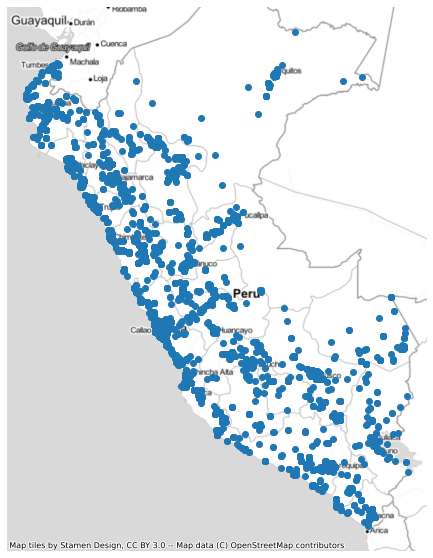

/var/folders/kb/8rst2bm96jq7g3ykfrtw15zc0000gp/T/ipykernel_9737/1441396406.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  geocoded_gdf_sin_direccion_ni_mzn_vb) = geocoding_process(


              count
count    272.000000
mean     137.224265
std     1099.374987
min        1.000000
25%        2.000000
50%        6.000000
75%       25.250000
max    17486.000000


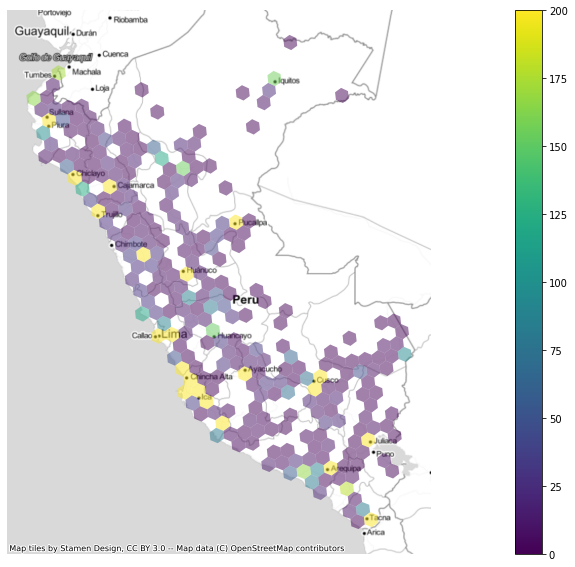

In [177]:
(geocoded_df_sin_direccion_ni_mzn_vb, 
 geocoded_gdf_sin_direccion_ni_mzn_vb) = geocoding_process(
    fn='outputs/geocoded_df_sin_direccion_ni_mzn_vb', 
    df=df_sin_direccion_ni_mzn_vb, 
    geocode_fn=geocode_w_poly
)

In [163]:
df_sin_direccion_ni_mzn_vb.shape

(78260, 36)

In [164]:
geocoded_gdf_sin_direccion_ni_mzn_vb.shape

(78260, 12)

In [187]:
not_geocoded = geocoded_gdf_sin_direccion_ni_mzn_vb['lat'].isna().values
df_sin_direc_ni_mzn_vb_retry = df_sin_direccion_ni_mzn_vb[not_geocoded].copy()

Valores nulos posibles encontrados:

['-' 'SN' 'S/N' '' 'S N' '.' 'S.N' '--' 
 'WS/N' 'REF'  'S-N'  'S/N-' 'S/Nº' 'S.N.' 'NULL' '---' 'REF.' 'SN-']

In [188]:
reduced_address_cols = ['DESCRIPCION_TIPO_VIA_clean', 'NOMBRE_VIA',
                        'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO']

In [189]:
query_string = (df_sin_direc_ni_mzn_vb_retry[reduced_address_cols].agg(' '.join, axis=1)
                .str.replace('-', '')
                .str.replace(r'  +', ' ', regex=True))

In [190]:
df_sin_direc_ni_mzn_vb_retry['q'] = query_string

In [192]:
df_sin_direc_ni_mzn_vb_retry.shape

(36337, 36)


Geocoded observations:
---------------------

Total:
-----
False    18629
True     17708
Name: lat, dtype: int64

Percentage:
----------
False    51.27
True     48.73
Name: lat, dtype: float64

OSM Data types:
--------------
way         10118
relation     7349
node         1162
Name: osm_type, dtype: int64

OSM Class:
---------
highway     9055
boundary    7315
place        871
amenity      565
shop         310
leisure      181
landuse      114
tourism       73
office        38
building      34
natural       22
waterway      16
aeroway       10
historic       8
railway        5
bridge         3
man_made       3
military       3
craft          2
club           1
Name: class, dtype: int64

OSM Class type:
--------------
administrative       7292
residential          6246
secondary             964
tertiary              797
trunk                 429
                     ... 
telecommunication       1
apartment               1
taxiway                 1
parking_position        1
water_park 

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,



GeoDataFrame (first 5 observations):
-----------------------------------
   place_id                                            licence osm_type  \
0  299981.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   
1       NaN                                                NaN      NaN   
2       NaN                                                NaN      NaN   
3  299981.0  Data © OpenStreetMap contributors, ODbL 1.0. h...     node   
4       NaN                                                NaN      NaN   

         osm_id          lat          lon  \
0  7.370342e+09  -12.1995795  -76.9728732   
1           NaN          NaN          NaN   
2           NaN          NaN          NaN   
3  7.370342e+09  -12.1995795  -76.9728732   
4           NaN          NaN          NaN   

                                        display_name   class        type  \
0  Agencia Municipal N° 1 de Villa El Salvador, A...  office  government   
1                                                NaN

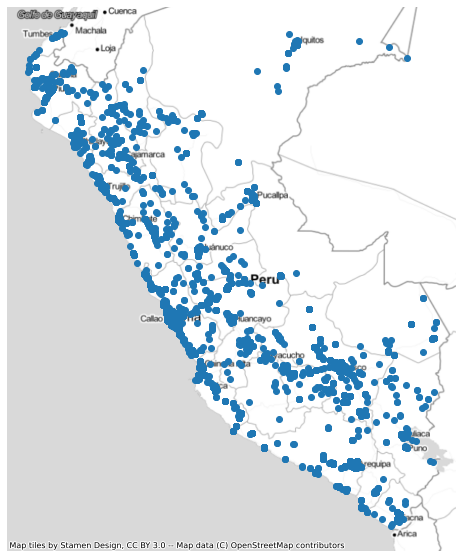

/var/folders/kb/8rst2bm96jq7g3ykfrtw15zc0000gp/T/ipykernel_9737/2582899507.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  geocoded_gdf_sin_direc_ni_mzn_vb_retry) = geocoding_process(


             count
count   242.000000
mean     70.632231
std     612.569049
min       1.000000
25%       2.000000
50%       5.500000
75%      16.750000
max    9448.000000


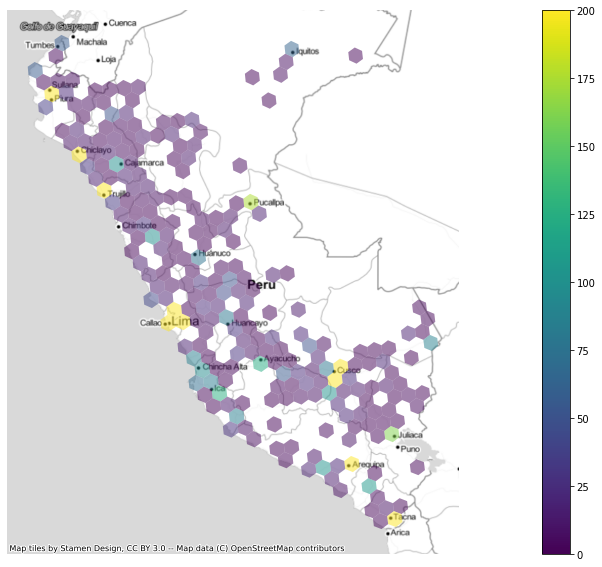

In [193]:
(geocoded_df_sin_direc_ni_mzn_vb_retry, 
 geocoded_gdf_sin_direc_ni_mzn_vb_retry) = geocoding_process(
    fn='outputs/geocoded_df_sin_direc_ni_mzn_vb_retry', 
    df=df_sin_direc_ni_mzn_vb_retry, 
    geocode_fn=geocode_w_poly
)

In [196]:
not_geocoded_on_retry = geocoded_gdf_sin_direc_ni_mzn_vb_retry['lat'].isna().values
df_sin_direc_ni_mzn_vb_left = df_sin_direc_ni_mzn_vb_retry[not_geocoded_on_retry].copy()

In [220]:
df_retry_nominatim_vb_left = df_retry_nominatim_vb[geocoded_gdf_retry_nominatim_vb['lat'].isna().values].copy()

In [221]:
df_sin_direc_ni_mzn_vb_left.shape

(17708, 36)

In [222]:
df_retry_nominatim_vb_left.shape

(37677, 35)

In [223]:
df_sin_direc_ni_mzn_vb_left.shape[0] + df_retry_nominatim_vb_left.shape[0]

55385

In [229]:
df_with_names

,ruc,RAZON_SOCIAL,NOMBRE_COMERCIAL,CODIGO_TIPO_VIA,DESCRIPCION_TIPO_VIA,NOMBRE_VIA,PUERTA,MANZANA,LOTE,PISO,...,CNS_FRENTE,DEPARTAMENTO,PROVINCIA,DISTRITO,CAPITAL,codigo_prov,Region,CODODEI,ODEI,UBIGEO
0,2.010000e+10,COCINA DE VUELO DOCAMPO S.A.C.,-,03,JIRON,APURIMAC,521,-,-,,...,,CALLAO,CALLAO,CALLAO,CALLAO,0701,07 Callao,15,Lima,070101
1,2.010000e+10,COMFER S A,,01,AVENIDA,ARGENTINA,1646,-,-,,...,,CALLAO,CALLAO,CALLAO,CALLAO,0701,07 Callao,15,Lima,070101
2,2.010000e+10,CROSLAND TECNICA S.A.,-,01,AVENIDA,AUGUSTO PEREZ ARANIBAR,1872,-,-,,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
3,2.010000e+10,FUNDICION CALLAO S.A.,,01,AVENIDA,ARGENTINA,3719,-,-,,...,,CALLAO,CALLAO,CALLAO,CALLAO,0701,07 Callao,15,Lima,070101
4,2.010000e+10,KOMFORT S A,-,05,CARRETERA,ANTIGUA PANAMERICANA SUR,-,-,-,,...,,LIMA,LIMA,VILLA EL SALVADOR,VILLA EL SALVADOR,1501,15 Provincia de Lima,15,Lima,150142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240146,2.060533e+10,C & C CONTROLS S.A.C.,,02,CALLE,MICAELA BASTIDAS,202,-,-,,...,,LIMA,LIMA,VILLA MARIA DEL TRIUNFO,VILLA MARIA DEL TRIUNFO,1501,15 Provincia de Lima,15,Lima,150143
240147,2.060533e+10,A Y R SERVICIOS LOGISTICOS E INVERSIONES E.I.R.L.,,02,CALLE,PROHOGAR,918,-,-,,...,,AREQUIPA,AREQUIPA,MIRAFLORES,MIRAFLORES,0401,04 Arequipa,05,Arequipa,040110
240148,2.060533e+10,WINSO E.I.R.L.,,02,CALLE,BACA MATTOS,1194,-,-,,...,,LAMBAYEQUE,LAMBAYEQUE,LAMBAYEQUE,LAMBAYEQUE,1403,14 Lambayeque,14,Chiclayo,140301
240149,2.060533e+10,SERVICIOS GENERALES LUCA RH E.I.R.L.,,06,OTROS,AGRUP. MI PERU,,J11,11,,...,,CALLAO,CALLAO,VENTANILLA,VENTANILLA,0701,07 Callao,15,Lima,070106


In [207]:
# segundos / minutos / horas
((df_sin_direc_ni_mzn_vb_left.shape[0] + df_second_retry.shape[0]) * 1.5) / 60 / 60

23.077083333333334

In [226]:
# Concatenate left dfs
df_left = pd.concat([df_sin_direc_ni_mzn_vb_left, df_retry_nominatim_vb_left])

In [245]:
# Get firm name
df_with_names = pd.read_stata("/Users/claudio/Downloads/rucs_firmas_20142020_v2.dta")

In [246]:
df_left_with_names = df_left.merge(df_with_names[['RAZON_SOCIAL']], left_index=True, right_index=True)
df_left_with_names['address_q'] = df_left_with_names['q']
df_left_with_names['q'] = df_left_with_names['RAZON_SOCIAL'].str.lower().str.replace('"', '')


Geocoded observations:
---------------------

Total:
-----
True     54823
False      562
Name: lat, dtype: int64

Percentage:
----------
True     98.99
False     1.01
Name: lat, dtype: float64

OSM Data types:
--------------
node        343
way         218
relation      1
Name: osm_type, dtype: int64

OSM Class:
---------
amenity     174
shop        168
office       63
highway      28
building     25
tourism      24
place        21
landuse      19
man_made     17
leisure      11
craft         7
waterway      3
natural       1
boundary      1
Name: class, dtype: int64

OSM Class type:
--------------
townhall           42
yes                38
company            29
restaurant         28
school             27
                   ..
christmas_store     1
office              1
motorcycle          1
water_works         1
administrative      1
Name: type, Length: 118, dtype: int64
    


/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,



GeoDataFrame (first 5 observations):
-----------------------------------
   place_id licence osm_type  osm_id  lat  lon display_name class type  \
0       NaN     NaN      NaN     NaN  NaN  NaN          NaN   NaN  NaN   
1       NaN     NaN      NaN     NaN  NaN  NaN          NaN   NaN  NaN   
2       NaN     NaN      NaN     NaN  NaN  NaN          NaN   NaN  NaN   
3       NaN     NaN      NaN     NaN  NaN  NaN          NaN   NaN  NaN   
4       NaN     NaN      NaN     NaN  NaN  NaN          NaN   NaN  NaN   

   importance     geometry  
0         NaN  POINT EMPTY  
1         NaN  POINT EMPTY  
2         NaN  POINT EMPTY  
3         NaN  POINT EMPTY  
4         NaN  POINT EMPTY  
    


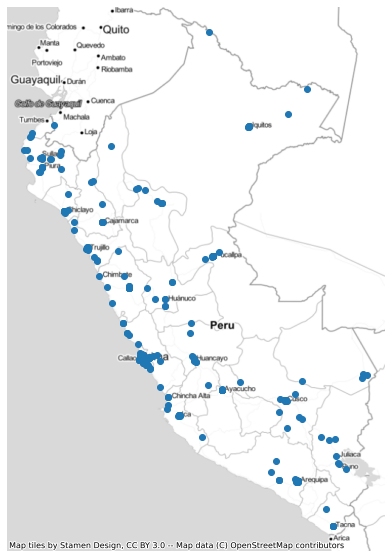

/var/folders/kb/8rst2bm96jq7g3ykfrtw15zc0000gp/T/ipykernel_9737/516963664.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  geocoded_gdf_left_with_names) = geocoding_process(


            count
count   72.000000
mean     7.416667
std     32.029366
min      1.000000
25%      1.000000
50%      1.000000
75%      4.000000
max    269.000000


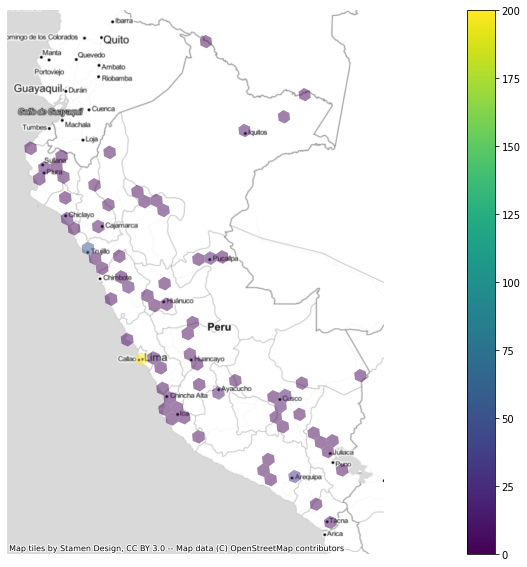

In [240]:
# Geocode with firm name and district viewbox
(geocoded_df_left_with_names, 
 geocoded_gdf_left_with_names) = geocoding_process(
    fn='outputs/geocoded_df_left_with_names', 
    df=df_left_with_names, 
    geocode_fn=geocode_w_poly
)

In [247]:
not_geocoded_with_names = geocoded_gdf_left_with_names['lat'].isna().values
df_not_geocoded_final = df_left_with_names[not_geocoded_with_names].copy()

In [248]:
# Save DataFrame as csv
df_not_geocoded_final.to_csv('outputs/df_not_geocoded_final.csv')